In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats

# Group comparisons
En este notebook vamos a empezar estudiando un solo grupo del dataset, y observar estadísticas para describirlo. Se compararán dos grupos y finalmente los test estadísticos t-test y Mann-Whitney U test.

In [2]:
mlb = pd.read_csv('d:\\cursos\\data_science\\data\\mlb.csv')

In [3]:
print('Shape:',mlb.shape)
mlb.head()

Shape: (1034, 6)


,name,team,position,height,weight,age
0,Adam_Donachie,BAL,Catcher,74,180.0,22.99
1,Paul_Bako,BAL,Catcher,74,215.0,34.69
2,Ramon_Hernandez,BAL,Catcher,72,210.0,30.78
3,Kevin_Millar,BAL,First_Baseman,72,210.0,35.43
4,Chris_Gomez,BAL,First_Baseman,73,188.0,35.71


## Estadística descriptiva

In [4]:
mlb.describe()

,height,weight,age
count,1034.000000,1033.000000,1034.000000
mean,73.697292,201.689255,28.736712
std,2.305818,20.991491,4.320310
min,67.000000,150.000000,20.900000
25%,72.000000,187.000000,25.440000
50%,74.000000,200.000000,27.925000
75%,75.000000,215.000000,31.232500
max,83.000000,290.000000,48.520000


Un diagrama de caja demuestra que varios valores resultan atípicas:

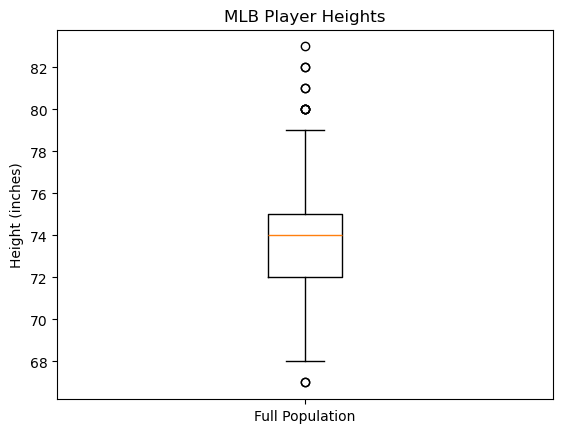

In [5]:
fig1, ax1 = plt.subplots()
ax1.boxplot(mlb.height)
ax1.set_ylabel('Height (inches)')
plt.title('MLB Player Heights')
plt.xticks([1], ['Full Population'])
plt.show()

## Muestras aleatorias
Las muestras aleatorias se utilizan para esperar resultados aplicables a la población general.

In [6]:
sample1 = mlb.sample(n=30, random_state=8675309)
sample2 = mlb.sample(n=30, random_state=1729)

Una tercera muestra seleccionada manualmente será contemplada. **El propósito es pensar la *procedencia* de una muestra, si dos muestras pertencen a la misma población, o de *dónde*.**

In [7]:
sample3=[71, 72, 73, 74, 74, 76, 75, 75, 75, 76, 75, 77, 76, 75, 77, 76,
         75,76, 76, 75, 75, 81,77, 75, 77, 75, 77, 77, 75, 75]

Examinemos de nuevo los diagramas de caja:

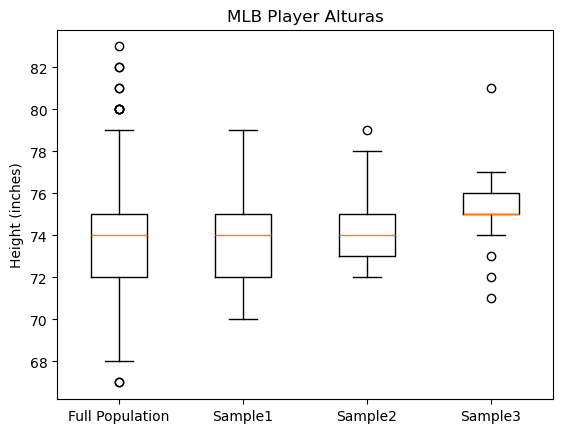

In [8]:
fig1, ax1 = plt.subplots()
ax1.boxplot([mlb.height, sample1.height, sample2.height, np.array(sample3)])
ax1.set_ylabel('Height (inches)')
plt.title('MLB Player Alturas')
plt.xticks([1,2,3,4], ['Full Population', 'Sample1', 'Sample2', 'Sample3'])
plt.show()

La media de la población recibe el nombre especial de **expected value** (valor esperado), esto quiere decir que la media de una muestra de la población se *espera* que sea del orden de la media poblacional.

In [9]:
print('Sample1:', np.mean(sample1.height))
print('Sample2:', np.mean(sample2.height))
print('Sample3:', np.mean(sample3))

Sample1: 73.8
Sample2: 74.36666666666666
Sample3: 75.43333333333334


## Diferencias entre las muestras
Al examinar los promedios, notamos diferentes grados de diferencia entre las muestras 1, 2 y 3 con respecto a la población. Para decidir con mayor precisión si una muestra pertenece o no a una población necesitamos un mejor método, **por ejemplo, examinar una gran cantidad de muestras**.

In [10]:
alldiferences=[]
for i in range(1000):
    newsample1 = mlb.sample(n=30, random_state=i*2)
    newsample2 = mlb.sample(n=30, random_state=i*2+1)
    alldiferences.append(newsample1['height'].mean()-newsample2['height'].mean())

In [11]:
alldiferences[0:10]

[0.8333333333333286,
 -0.30000000000001137,
 -0.10000000000000853,
 -0.1666666666666572,
 0.06666666666667709,
 -0.9666666666666686,
 0.7999999999999972,
 0.9333333333333371,
 -0.5333333333333314,
 -0.20000000000000284]

Observando las diferencias nos damos cuenta que una diferencia de 1.6 entre las muestras no figura en este rango, probablemente es más implausible que la muestra 3 pertenezca a la población. Vamos a observar un gráfico:

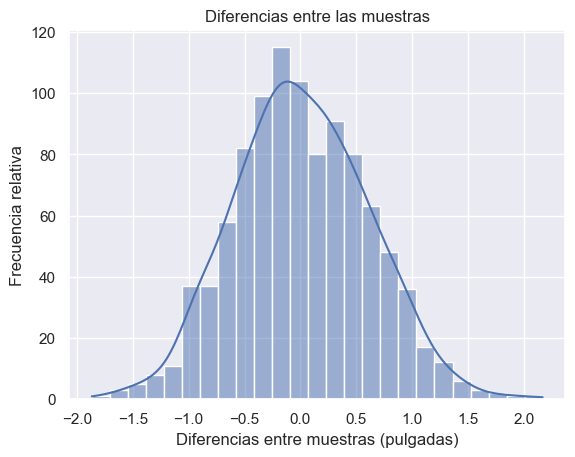

In [12]:
sns.set()
ax = sns.histplot(alldiferences, kde=True).set_title("Diferencias entre las muestras")
plt.xlabel("Diferencias entre muestras (pulgadas)")
plt.ylabel("Frecuencia relativa")
plt.show()

### Teorema del límite central
Como se puede observar, es *poco común* que las muestras tengan una diferencia mayor que 1, por lo tanto, la muestra 3 es poco plausible que pertenezca a la población.

El **teorema del límite central** establece que bajo las siguientes condiciones, una distribución tendra la forma de campana:
* Las muestras son independientes e idénticamente distribuidas (aleatoridad).
* La población tiene un valor esperado finito.
* La población tiene una varianza finita.

Veámos cuántas observaciones coinciden en ser mayor que 1.6:

In [13]:
largedifferences = [diff for diff in alldiferences if abs(diff) >= 1.6]
len(largedifferences)

8

Esto significa que una diferencia mayor o igual a 1.6 ocurre solo en un 0.8%, es muy raro. El $p$-value indica que podemos rechazar la idea de que sample3 no pertence a la población. Por el contrario, el $p$-value de las sample1 y sample2 resulta factible:

In [14]:
smalldifferences = [diff for diff in alldiferences if abs(diff)>=0.6]
len(smalldifferences)

314

## Hyphotesis testing
El análisis anterior puede enunciar con más formalidad de la siguiente manera. Suponga que analizamos dos muestras, sample1 y sample2, para definir si pertenecen o no a la misma población. Tenemos las siguientes hipótesis:
* **Hipótesis 0**: sample1 y sample2 pertenecen a la misma población. Hipótesis nula.
* **Hipótesis 1**: sample1 y sample2 no pertenecen a la misma población. Hipótesis alternativa.

Comprobemos con los siguientes pasos:
* Asumimos que la hipótesis 0 es verdadera.
* Encontramos qué tan probable es observar una diferencia entre las medias muestrales, como la diferencia entre sample1 y sample3, en el conujunto de datos, asumiendo que hipótesis 0 es cierta. Esto se denomina $p$-value.
* Si $p$-value es *significativamente* bajo, rechazamos la hipótesis 0 y por lo tanto aceptamos la hipótesis 1.

Nosotros, con nuestra intuición y juicio establecemos el *nivel significativo*, qué significa *bajo* para $p$-value. Si nuestro $p$-value es menor que el nivel significativo, decimos que la diferencia en nuestras muestras es *estadísticamente significativa*.

Se recomienda establecer el nivel significativo antes de ejecutar el test, para evitar sesgos.

## t-test
La librería `scipy` tiene una implementación del t-test. Por ejemplo, evaluando sample1 y sample2 notamos que el $p$-value resulta favorable, y nos quedamos con la hipótesis nula.

In [16]:
scipy.stats.ttest_ind(sample1['height'], sample2['height'])

TtestResult(statistic=-1.0839563860213952, pvalue=0.2828695892305152, df=58.0)

Al tratar con sample1 y sample3, el $p$-value es bajo.

In [18]:
scipy.stats.ttest_ind(sample1['height'], sample3)

TtestResult(statistic=-3.108694797644094, pvalue=0.002910554741439718, df=58.0)

***Independiente***, en este contexto, significa que no hay una relación significativa entre muestras, cada individuo está seleccionado aleatoriamente.

Para aplicar el test con muestras que estén relacionadas, p. ej. si se tratan datos con respecto a un mismo individuo, se aplica el método
```python
scipy.stats.ttest_rel() # t-test relacionado
```
Además, t-test supone que las varianzas de las muestras son similares. El *Welch's t-test* no supone que las varianzas son iguales. Se implementa con el parámetro `equal_var = False` en t-test.

In [19]:
scipy.stats.mannwhitneyu(sample1['height'], sample2['height'])

MannwhitneyuResult(statistic=392.0, pvalue=0.38913738408151577)

### Test paramétricos y no-paramétricos
La prueba t-test admite ciertas suposiciones sobre la distribución de los datos, por lo cual recibe el nombre de *test paramétrico*. Admite que:
* Los grupos comparados tienen medias muestrales con forma de campana.
* Las varianzas de los grupos son idénticas (excepte en Welch's t-test).
* Los grupos son independientes.

Para realizar un test donde no hagamos tantas suposiciones preferimos el enfoque llamado *estadísticas no-paramétricas*. La versión no-paramétricas de t-test es *Mann-Whitney U test* o *Wilcoxon rank-sum-test*.
```python
scipy.stats.mannwhitneyu() # Mann Whitney U test
```

## Caso de estudio

In [23]:
desktop = pd.read_csv('d:\\cursos\\data_science\\data\\desktop.csv')
laptop = pd.read_csv('d:\\cursos\\data_science\\data\\laptop.csv')

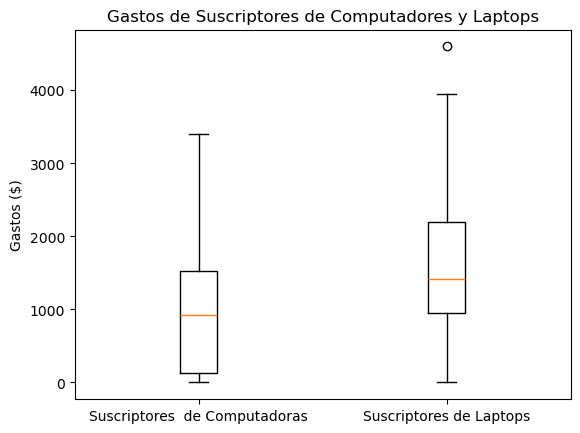

In [32]:
sns.reset_orig()
fig1, ax1 = plt.subplots()
ax1.set_title('Gastos de Suscriptores de Computadores y Laptops')
ax1.boxplot([desktop['spending'].values, laptop['spending'].values])
ax1.set_ylabel('Gastos ($)')
plt.xticks([1,2], ['Suscriptores  de Computadoras', 'Suscriptores de Laptops'])
plt.show()

In [33]:
print(np.mean(desktop['age']))
print(np.mean(laptop['age']))
print(np.median(desktop['age']))
print(np.median(laptop['age']))
print(np.quantile(laptop['spending'],.25))
print(np.quantile(desktop['spending'],.75))
print(np.std(desktop['age']))

35.766666666666666
38.733333333333334
32.0
33.0
957.5
1528.25
14.943634839697543


In [34]:
scipy.stats.ttest_ind(laptop['spending'], desktop['spending'])

TtestResult(statistic=2.109853741030508, pvalue=0.03919630411621095, df=58.0)